In [1]:
import os 
import opendssdirect as dss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az
import networkx as nx
import pandapower as pp
import pandapower.networks as pn

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV
import math
import pytensor
import pickle
import copy
import random

In [2]:
def generate_power_data_df(three_phase_model):
    with three_phase_model:
        idata = pm.sample(draws=100,chains=4,tune=10)


    #generating df_dict
    [num_chains,num_samples,num_loads]=idata.posterior['P_a'].shape

    sample_idx=0

    df_dict={}

    load_list_a=[[] for k_idx in range(num_loads)]
    load_list_b=[[] for k_idx in range(num_loads)]
    load_list_c=[[] for k_idx in range(num_loads)]

    df_dict=pd.DataFrame(columns=['sample_idx','node','p_a','q_a','p_b','q_b','p_c','q_c','num_phases','distance'])
    real_p_a_array=copy.deepcopy(idata.posterior['real_p_a'].values)
    real_p_b_array=copy.deepcopy(idata.posterior['real_p_b'].values)
    real_p_c_array=copy.deepcopy(idata.posterior['real_p_c'].values)
    real_q_a_array=copy.deepcopy(idata.posterior['real_q_a'].values)
    real_q_b_array=copy.deepcopy(idata.posterior['real_q_b'].values)
    real_q_c_array=copy.deepcopy(idata.posterior['real_q_c'].values)
    three_phase_choice_array=copy.deepcopy(idata.posterior['three_phase_choice'].values)


    for i in range(num_chains): #chains
        print(i)
        for j in range(num_samples): #samples
            for k in range(num_loads):
                distance=normalized_dist_dict[k]
                phase_a_p=float(real_p_a_array[i][j][k])
                phase_a_q=float(real_q_a_array[i][j][k])
                phase_b_p=float(real_p_b_array[i][j][k])
                phase_b_q=float(real_q_b_array[i][j][k])
                phase_c_p=float(real_p_c_array[i][j][k])
                phase_c_q=float(real_q_c_array[i][j][k])
                num_phases=float(three_phase_choice_array[i][j][k])
                df_dict.loc[len(df_dict)]=[sample_idx,k,phase_a_p,phase_a_q,phase_b_p,phase_b_q,phase_c_p,phase_c_q,num_phases,distance]
        
            sample_idx+=1

    user_input_p=[]
    user_input_q=[]
    power_data_df=pd.DataFrame(columns=['source','power_type','phase','value'])
    error_dict={'p_a':[],
                'p_b':[],
                'p_c':[],
                'q_a':[],
                'q_b':[],
                'q_c':[],
                }


    user_input_p_a_list=[]
    for node_idx in graph_from_net.nodes:
        p_a=np.mean(df_dict[(df_dict.node==node_idx)].p_a)
        q_a=np.mean(df_dict[(df_dict.node==node_idx)].q_a)
        p_b=np.mean(df_dict[(df_dict.node==node_idx)].p_b)
        q_b=np.mean(df_dict[(df_dict.node==node_idx)].q_b)
        p_c=np.mean(df_dict[(df_dict.node==node_idx)].p_c)
        q_c=np.mean(df_dict[(df_dict.node==node_idx)].q_c)

        user_input_p_a=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_a_mw)
        user_input_p_b=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_b_mw)
        user_input_p_c=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_c_mw)
        user_input_q_a=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_a_mvar)
        user_input_q_b=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_b_mvar)
        user_input_q_c=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_c_mvar)

        #real data
        power_data_df.loc[len(power_data_df)]=['model','p','a',p_a]
        power_data_df.loc[len(power_data_df)]=['model','q','b',q_a]
        power_data_df.loc[len(power_data_df)]=['model','p','c',p_b]
        power_data_df.loc[len(power_data_df)]=['model','q','a',q_b]
        power_data_df.loc[len(power_data_df)]=['model','p','b',p_c]
        power_data_df.loc[len(power_data_df)]=['model','q','c',q_c]


        
        #user input
        if(user_input_p_a!=0):
            user_input_p_a_list.append(user_input_p_a)
            error_dict['p_a'].append(np.abs(((p_a-user_input_p_a)/user_input_p_a)))
            power_data_df.loc[len(power_data_df)]=['user_input','p','a',user_input_p_a]
        if(user_input_p_b!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','p','b',user_input_p_b]
            error_dict['p_b'].append(np.abs(((p_b-user_input_p_b)/user_input_p_b)))
        if(user_input_p_c!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','p','c',user_input_p_c]
            error_dict['p_c'].append(np.abs(((p_c-user_input_p_c)/user_input_p_c)))
        if(user_input_q_a!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','q','a',user_input_q_a]
            error_dict['q_a'].append(np.abs(((q_a-user_input_q_a)/user_input_q_a)))
        if(user_input_q_b!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','q','b',user_input_q_b]
            error_dict['q_b'].append(np.abs(((q_b-user_input_q_b)/user_input_q_b)))
        if(user_input_q_c!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','q','c',user_input_q_c]
            error_dict['q_c'].append(np.abs(((q_c-user_input_q_c)/user_input_q_c)))

    return [power_data_df,error_dict]


# Transfer Learning - step by step
1) data from OEDI will be used to feed the pymc model
2) we will sample the probabilities of being 3 phase (based on distance) as well as active and reactive power using only OEDI data, and apply into another system whose data we already know
3) we will see how close to the real mean active and reactive power - as well as mean 3-phase probability - is from the sampled ones

sample is from system "A (oedi in this case), but we apply it into system B (ieee european lv)


important: normalize active and reactive power -> unnormalize after

# System A data and pymc model

In [3]:
to_save_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_3_phase_synthetic\generated_data'

prob_3_phases=pickle.load(open(os.path.join(to_save_folder,'prob_3_phases.pickle'),'rb'))

phases_proportion=pickle.load(open(os.path.join(to_save_folder,'phases_proportion.pickle'),'rb'))

phases_planning=pickle.load(open(os.path.join(to_save_folder,'phases_planning.pickle'),'rb'))

power_df=pickle.load(open(os.path.join(to_save_folder,'power_df.pickle'),'rb'))

## setting up system B and calculating normalized distance

In [20]:
graph_from_net[1]

AtlasView({2: {'key': ('line', 0), 'weight': 0.001097999978811, 'path': 1}})

In [ ]:

net=pn.ieee_european_lv_asymmetric() #simulated network: a real 3-phase system found in the pandapower library
graph_from_net=pp.topology.create_nxgraph(net,include_trafos=False,multi=False,)

# defining x and y coordinates for each bus

x_dict={}
y_dict={}

for bus_idx in net.bus.index:
    x_dict[bus_idx]=net.bus_geodata.at[bus_idx,'x']
    y_dict[bus_idx]=net.bus_geodata.at[bus_idx,'y']

nx.set_node_attributes(graph_from_net,x_dict,'x')
nx.set_node_attributes(graph_from_net,y_dict,'y')


# defining the x and y for the gen
bus_gen=0
x_gen=net.bus_geodata.at[bus_gen,'x']
y_gen=net.bus_geodata.at[bus_gen,'y']

#calculating max distance (from a given node to feeder)

max_distance=0
for node in graph_from_net.nodes:
    x=graph_from_net.nodes[node]['x']
    y=graph_from_net.nodes[node]['y']
    distance=np.sqrt((x-x_gen)**2+(y-y_gen)**2)
    if(distance>max_distance):
        max_distance=distance


AttributeError: 'pandapowerNet' instance has no attribute 'bus_geodata'

In [15]:
net=pn.ieee_european_lv_asymmetric() #simulated network: a real 3-phase system found in the pandapower library

In [21]:
three_phi_p_a=net.asymmetric_load[(net.asymmetric_load.p_a_mw!=0) & (net.asymmetric_load.p_b_mw!=0) & (net.asymmetric_load.p_c_mw!=0)].p_a_mw
three_phi_p_b=net.asymmetric_load[(net.asymmetric_load.p_a_mw!=0) & (net.asymmetric_load.p_b_mw!=0) & (net.asymmetric_load.p_c_mw!=0)].p_b_mw
three_phi_p_c=net.asymmetric_load[(net.asymmetric_load.p_a_mw!=0) & (net.asymmetric_load.p_b_mw!=0) & (net.asymmetric_load.p_c_mw!=0)].p_c_mw

single_phi_p_a=net.asymmetric_load[(net.asymmetric_load.p_a_mw!=0) & (net.asymmetric_load.p_b_mw==0) & (net.asymmetric_load.p_c_mw==0)].p_a_mw
single_phi_p_b=net.asymmetric_load[(net.asymmetric_load.p_a_mw==0) & (net.asymmetric_load.p_b_mw!=0) & (net.asymmetric_load.p_c_mw==0)].p_b_mw
single_phi_p_c=net.asymmetric_load[(net.asymmetric_load.p_a_mw==0) & (net.asymmetric_load.p_b_mw==0) & (net.asymmetric_load.p_c_mw!=0)].p_c_mw

In [22]:
phases_line_list=[]
priori_prop_three_phase_dict={}
normalized_dist_dict={}
node_list=list(graph_from_net.nodes)
node_list.sort()


for u,v in graph_from_net.edges():
    x_line=graph_from_net.nodes[v]['x']
    y_line=graph_from_net.nodes[v]['y']
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    #print(normalized_dist)
    

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])

    random_number=np.random.rand() #random for line
    if(random_number<=individual_prob_list[0]):
        phases_line_list.append(1)
    elif(random_number<=individual_prob_list[1]):
        phases_line_list.append(2)
    else:
        phases_line_list.append(3)

for u in node_list:
    x_line=graph_from_net.nodes[u]['x']
    y_line=graph_from_net.nodes[u]['y']
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    normalized_dist_dict[u]=normalized_dist
    #print(normalized_dist)

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    #individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])


    priori_prop_three_phase_dict[u]=prob_3_phases[3][rounded_dist]

KeyError: 'x'

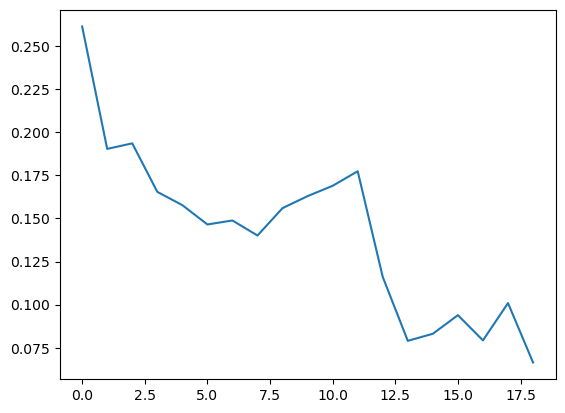

In [23]:
plt.plot(list(prob_3_phases[3].values()))

In [24]:
# normalizing active power

# copy the data 
normalized_power_df = power_df.copy() 
  
# apply normalization techniques 
for column in ['p_kw','q_kvar']: 
    normalized_power_df[column] = (normalized_power_df[column]-normalized_power_df[column].min())  / (normalized_power_df[column].max() - normalized_power_df[column].min())



In [25]:
#using active power from system A (oedi data)
individual_aggregated_power=normalized_power_df['p_kw'].mean() 


# taking node list from system B (european LV)
net=pn.ieee_european_lv_asymmetric() #simulated network: a real 3-phase system found in the pandapower library
graph_from_net=pp.topology.create_nxgraph(net,include_trafos=False,multi=False)
node_list=list(graph_from_net.nodes)
node_list.sort()


aggregated_power_dict={}
phases_proportion=np.zeros(shape=(len(node_list),3))
p_phases_choice=np.zeros(shape=(len(node_list),3))
prob_three_phases_dict={}





for bus in node_list:
    aggregated_power_dict[bus]=power_df['p_kw'].mean()
    phases_proportion[bus][:]=[1/3,1/3,1/3]
    p_phases_choice[bus][:]=[1/3,1/3,1/3]
    prob_three_phases_dict[bus]=priori_prop_three_phase_dict[bus]

KeyError: 0

In [26]:
#num_single_loads
#num_three_phase_loads
#phases_planning
#phases_proportion

def generate_3_phase_model(graph_from_net,aggregated_power_dict,prob_three_phases_dict,phases_proportion,p_phases_choice):
    with pm.Model() as three_phase_model:
        feeder_idx=0


        # proportion of each phase
        num_total_loads=len(graph_from_net.nodes)
        #num_total_loads=5
        #num_total_loads=int(num_single_loads[feeder_idx]+num_three_phase_loads[feeder_idx])
        #prop_three_phase=num_three_phase_loads[feeder_idx]/num_total_loads
        prob_three_phases_data=list(prob_three_phases_dict.values())
        #prob_three_phase=0

        three_phase_choice=pm.Bernoulli('three_phase_choice',p=prob_three_phases_data,shape=num_total_loads)



        mu_prop_a=np.mean([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
        #var_prop_a=np.std([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
        #prop_a=pm.TruncatedNormal('prop_a',mu=mu_prop_a,sigma=var_prop_a,shape=num_total_loads,lower=0)

        mu_prop_b=np.mean([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
        #var_prop_b=np.std([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
        #prop_b=pm.TruncatedNormal('prop_b',mu=mu_prop_b,sigma=var_prop_b,shape=num_total_loads,lower=0)

        mu_prop_c=np.mean([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
        #var_prop_c=np.std([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
        #prop_c=pm.TruncatedNormal('prop_c',mu=mu_prop_c,sigma=var_prop_c,shape=num_total_loads,lower=0)

        # phase choice


        phase_choice=pm.Categorical('phase_choice',p=p_phases_choice,shape=(num_total_loads))


        # defining load of each phase
        #mu_p_a=np.mean([phases_planning[idx][0] for idx in range(len(phases_planning))])
        mu_p_a=np.array(list(aggregated_power_dict.values()))
        normalizing_constant=[phases_planning[idx][0] for idx in range(len(phases_planning))]/max([phases_planning[idx][0] for idx in range(len(phases_planning))])
        var_p_a=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
        #expected_p_a=pm.Deterministic('mu_p_a',mu_p_a/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_a))) #phase a
        p_a=pm.TruncatedNormal('P_a',mu=mu_p_a,sigma=var_p_a,lower=0,shape=(num_total_loads))

        #mu_p_b=np.mean([phases_planning[idx][1] for idx in range(len(phases_planning))])
        mu_p_b=np.array(list(aggregated_power_dict.values()))
        normalizing_constant=[phases_planning[idx][1] for idx in range(len(phases_planning))]/max([phases_planning[idx][1] for idx in range(len(phases_planning))])
        var_p_b=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
        #expected_p_b=pm.Deterministic('mu_p_b',mu_p_b/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_b))) #phase b
        p_b=pm.TruncatedNormal('P_b',mu=mu_p_b,sigma=var_p_b,lower=0,shape=(num_total_loads))

        #mu_p_c=np.mean([phases_planning[idx][2] for idx in range(len(phases_planning))])
        mu_p_c=np.array(list(aggregated_power_dict.values()))
        normalizing_constant=[phases_planning[idx][2] for idx in range(len(phases_planning))]/max([phases_planning[idx][2] for idx in range(len(phases_planning))])
        var_p_c=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
        #expected_p_c=pm.Deterministic('mu_p_c',mu_p_c/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_c))) #phase c
        p_c=pm.TruncatedNormal('P_c',mu=mu_p_c,sigma=var_p_c,lower=0,shape=(num_total_loads))


        real_p_a=pm.Deterministic('real_p_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),p_a,0),p_a*mu_prop_a))
        real_p_b=pm.Deterministic('real_p_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),p_b,0),p_b*mu_prop_b))
        real_p_c=pm.Deterministic('real_p_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),p_c,0),p_c*mu_prop_c))



        power_factor_mu=0.95
        power_factor=pm.Beta('power_factor',mu=power_factor_mu,sigma=power_factor_mu*0.05,shape=num_total_loads)

        var_q_a=np.sqrt((var_p_a/power_factor_mu)**2-var_p_a**2)
        var_q_b=np.sqrt((var_p_b/power_factor_mu)**2-var_p_b**2)
        var_q_c=np.sqrt((var_p_c/power_factor_mu)**2-var_p_c**2)

        q_a=pm.TruncatedNormal('Q_a',mu=np.sqrt((mu_p_a/power_factor_mu)**2-mu_p_a**2),sigma=var_q_a,lower=0,shape=(num_total_loads))
        q_b=pm.TruncatedNormal('Q_b',mu=np.sqrt((mu_p_b/power_factor_mu)**2-mu_p_b**2),sigma=var_q_b,lower=0,shape=(num_total_loads))
        q_c=pm.TruncatedNormal('Q_c',mu=np.sqrt((mu_p_c/power_factor_mu)**2-mu_p_c**2),sigma=var_q_c,lower=0,shape=(num_total_loads))

        real_q_a=pm.Deterministic('real_q_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),q_a,0),q_a*mu_prop_a))
        real_q_b=pm.Deterministic('real_q_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),q_b,0),q_b*mu_prop_b))
        real_q_c=pm.Deterministic('real_q_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),q_c,0),q_c*mu_prop_c))

        #phases_planning[feeder_idx]
        #active_power_load=pm.Normal(mu=)
    return three_phase_model

In [27]:
three_phase_model=generate_3_phase_model(graph_from_net,aggregated_power_dict,prob_three_phases_dict,phases_proportion,p_phases_choice)

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\discrete.py:1142: UserWarning: `p` parameters sum to [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

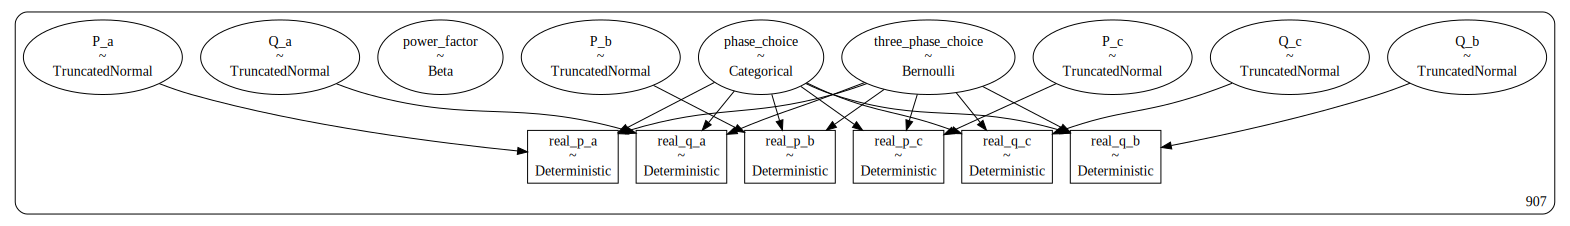

In [28]:
pm.model_to_graphviz(three_phase_model)

In [10]:
with three_phase_model:
    idata = pm.sample(draws=100,chains=4,tune=100)

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 395 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Storing idata 

In [4]:
to_save_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_3_phase_synthetic\results\transfer_learning'

#pickle.dump(idata,open(os.path.join(to_save_folder,'idata.pickle'),'wb'))

idata=pickle.load(open(os.path.join(to_save_folder,'idata.pickle'),'rb'))

### Transfer learning ability - p_3_phi

In [32]:
[num_chains,num_samples,num_loads]=idata.posterior['P_a'].shape

p_three_phase_target=[]
for chain in range(num_chains):
    for sample in range(num_samples):
        p_three_phase_target.append(sum(idata.posterior.three_phase_choice[chain][sample].values)/num_loads)
        


In [54]:
mean_3_phi_source=np.sum(sum(net.asymmetric_load.p_a_mw!=0)/(3*(len(net.asymmetric_load.index)))+sum(net.asymmetric_load.p_b_mw!=0)/(3*(len(net.asymmetric_load.index)))+sum(net.asymmetric_load.p_c_mw!=0)/(3*(len(net.asymmetric_load.index))))/3

In [55]:
mean_3_phi_target=np.mean(p_three_phase)

In [56]:
print(mean_3_phi_source)
print('target',mean_3_phi_target)
print('mape',np.abs(mean_3_phi_source-mean_3_phi_target)/mean_3_phi_target)

0.11111111111111112
target 0.12429713340683574
mape 0.10608468541720568


### transfer learning ability - p_phi(a/b/c)

In [31]:
prob_phi_a=len(net.asymmetric_load[(net.asymmetric_load.p_a_mw!=0) & (net.asymmetric_load.p_b_mw==0) & (net.asymmetric_load.p_c_mw==0)].index)/len(net.asymmetric_load.index)
prob_phi_b=len(net.asymmetric_load[(net.asymmetric_load.p_a_mw==0) & (net.asymmetric_load.p_b_mw!=0) & (net.asymmetric_load.p_c_mw==0)].index)/len(net.asymmetric_load.index)
prob_phi_c=len(net.asymmetric_load[(net.asymmetric_load.p_a_mw==0) & (net.asymmetric_load.p_b_mw==0) & (net.asymmetric_load.p_c_mw!=0)].index)/len(net.asymmetric_load.index)
normalization=prob_phi_a+prob_phi_b+prob_phi_c
print('prob_phi_a source',prob_phi_a/normalization)
print('prob_phi_b source',prob_phi_b/normalization)
print('prob_phi_c source',prob_phi_c/normalization)
prob_phi_a_source=prob_phi_a/normalization
prob_phi_b_source=prob_phi_b/normalization
prob_phi_c_source=prob_phi_c/normalization

prob_phi_a source 0.3269230769230769
prob_phi_b source 0.3653846153846154
prob_phi_c source 0.3076923076923077


In [73]:
import numpy as np
ar=np.array(phases_proportion)
prob_phi_c_target=np.mean(ar[:,0])
prob_phi_b_target=np.mean(ar[:,1])
prob_phi_a_target=np.mean(ar[:,2])
print('prob_phi_a target',prob_phi_c_target)
print('prob_phi_b target',prob_phi_c_target)
print('prob_phi_c target',prob_phi_c_target)

prob_phi_a target 0.32493101041666667
prob_phi_b target 0.32493101041666667
prob_phi_c target 0.32493101041666667


In [75]:
print('mape prob_phi_a',np.abs(prob_phi_a_source-prob_phi_a_target)/prob_phi_a_source)
print('mape prob_phi_a',np.abs(prob_phi_b_source-prob_phi_b_target)/prob_phi_b_source)
print('mape prob_phi_a',np.abs(prob_phi_c_source-prob_phi_c_target)/prob_phi_c_source)

mape prob_phi_a 0.12259261160714285
mape prob_phi_a 0.04577252467105266
mape prob_phi_a 0.1914137048611112


In [76]:
net.asymmetric_load

,name,bus,p_a_mw,q_a_mvar,p_b_mw,q_b_mvar,p_c_mw,q_c_mvar,sn_mva,scaling,in_service,type,description,sernum,for_name,chr_name
0,LOAD1,34,0.000574,0.000189,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,1.0,True,wye,,,,
1,LOAD2,47,0.000000,0.000000,0.000044,1.446210e-08,0.000000,0.000000e+00,NaN,1.0,True,wye,,,,
2,LOAD3,70,0.000114,0.000037,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,1.0,True,wye,,,,
3,LOAD4,73,0.000231,0.000076,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,1.0,True,wye,,,,
4,LOAD5,74,0.000035,0.000012,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,1.0,True,wye,,,,
5,LOAD6,83,0.000000,0.000000,0.000395,1.298302e-07,0.000000,0.000000e+00,NaN,1.0,True,wye,,,,
6,LOAD7,178,0.000000,0.000000,0.000055,1.807763e-08,0.000000,0.000000e+00,NaN,1.0,True,wye,,,,
7,LOAD8,208,0.000000,0.000000,0.000000,0.000000e+00,0.002836,9.321481e-07,NaN,1.0,True,wye,,,,
8,LOAD9,225,0.000131,0.000043,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,1.0,True,wye,,,,
9,LOAD10,248,0.000000,0.000000,0.002798,9.196581e-07,0.000000,0.000000e+00,NaN,1.0,True,wye,,,,


In [11]:
import scipy

# everything for Pa

flatten_pa_pymc=idata.posterior['P_a'].values.flatten()

norm_flatten_pa=(flatten_pa_pymc-flatten_pa_pymc.min())/(flatten_pa_pymc.max()-flatten_pa_pymc.min())

lv_mean=np.mean(1000*net.res_asymmetric_load_3ph.p_a_mw)
lv_std=np.std(1000*net.res_asymmetric_load_3ph.p_a_mw)

with pm.Model() as lv_model:
    x = pm.Normal("x", mu=lv_mean, sigma=lv_std)

with lv_model:
    idata_lv = pm.sample(draws=100,chains=4,tune=10)

flatten_lv=idata_lv.posterior['x'].values.flatten()

norm_flatten_lv_a=(flatten_lv-flatten_lv.min())/(flatten_lv.max()-flatten_lv.min())

# everything for Pb

flatten_pb_pymc=idata.posterior['P_b'].values.flatten()

norm_flatten_pb=(flatten_pb_pymc-flatten_pb_pymc.min())/(flatten_pb_pymc.max()-flatten_pb_pymc.min())

lv_mean=np.mean(1000*net.res_asymmetric_load_3ph.p_b_mw)
lv_std=np.std(1000*net.res_asymmetric_load_3ph.p_b_mw)

with pm.Model() as lv_model:
    x = pm.Normal("x", mu=lv_mean, sigma=lv_std)

with lv_model:
    idata_lv = pm.sample(draws=100,chains=4,tune=10)

flatten_lv=idata_lv.posterior['x'].values.flatten()

norm_flatten_lv_b=(flatten_lv-flatten_lv.min())/(flatten_lv.max()-flatten_lv.min())

# everything for Pc

flatten_pc_pymc=idata.posterior['P_c'].values.flatten()

norm_flatten_pc=(flatten_pc_pymc-flatten_pc_pymc.min())/(flatten_pc_pymc.max()-flatten_pc_pymc.min())

lv_mean=np.mean(1000*net.res_asymmetric_load_3ph.p_c_mw)
lv_std=np.std(1000*net.res_asymmetric_load_3ph.p_c_mw)

with pm.Model() as lv_model:
    x = pm.Normal("x", mu=lv_mean, sigma=lv_std)

with lv_model:
    idata_lv = pm.sample(draws=100,chains=4,tune=10)

flatten_lv=idata_lv.posterior['x'].values.flatten()

norm_flatten_lv_c=(flatten_lv-flatten_lv.min())/(flatten_lv.max()-flatten_lv.min())





Only 100 samples in chain.


KeyboardInterrupt: 

## Checking transfer learning ability - active power

In [ ]:
print('comparison pa; oedi data: {}; lv system: {}; error (%): {}'.format(np.mean(norm_flatten_pa),np.mean(norm_flatten_lv_a),np.abs(100*(np.mean(norm_flatten_pa)-np.mean(norm_flatten_lv_a))/np.mean(norm_flatten_lv_a))))
print('comparison pa; oedi data: {}; lv system: {}; error (%): {}'.format(np.mean(norm_flatten_pb),np.mean(norm_flatten_lv_b),np.abs(100*(np.mean(norm_flatten_pb)-np.mean(norm_flatten_lv_b))/np.mean(norm_flatten_lv_b))))
print('comparison pa; oedi data: {}; lv system: {}; error (%): {}'.format(np.mean(norm_flatten_pc),np.mean(norm_flatten_lv_c),np.abs(100*(np.mean(norm_flatten_pc)-np.mean(norm_flatten_lv_c))/np.mean(norm_flatten_lv_c))))

comparison pa; oedi data: 0.4544386725667735; lv system: 0.4235525041170585; error (%): 7.292169955198488
comparison pa; oedi data: 0.4340749793715198; lv system: 0.45555514215122883; error (%): 4.715161962232523
comparison pa; oedi data: 0.46394211063344576; lv system: 0.4828491482523084; error (%): 3.9157235106031383


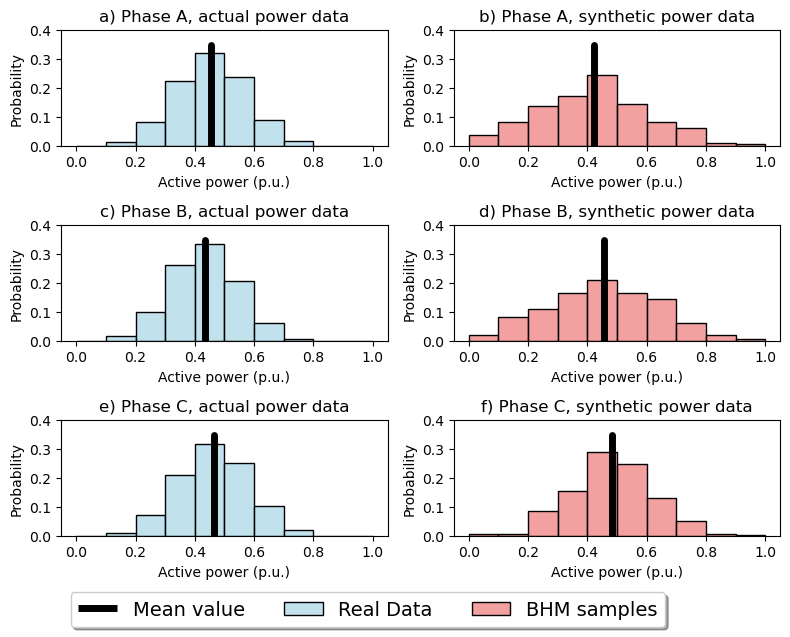

In [14]:
plt.rcParams["figure.figsize"] = (8,6)

fig,axs=plt.subplots(3,2)
#sns.histplot(normalized_power_df,x='p_kw',stat='probability',ax=axs[0])
sns.histplot(norm_flatten_pa,stat='probability',ax=axs[0][0],bins=10,color='lightblue')
axs[0][0].vlines(np.mean(norm_flatten_pa),0,0.35,label='Mean value',colors='black',linewidth=5)
axs[0][0].set_title('a) Phase A, actual power data')

sns.histplot(norm_flatten_lv_a,stat='probability',ax=axs[0][1],bins=10,color='lightcoral',)
axs[0][1].vlines(np.mean(norm_flatten_lv_a),0,0.35,colors='black',linewidth=5)
axs[0][1].set_title('b) Phase A, synthetic power data')

sns.histplot(norm_flatten_pb,stat='probability',ax=axs[1][0],bins=10,color='lightblue')
axs[1][0].vlines(np.mean(norm_flatten_pb),0,0.35,colors='black',linewidth=5)
axs[1][0].set_title('c) Phase B, actual power data')

sns.histplot(norm_flatten_lv_b,stat='probability',ax=axs[1][1],bins=10,color='lightcoral')
axs[1][1].vlines(np.mean(norm_flatten_lv_b),0,0.35,colors='black',linewidth=5)
axs[1][1].set_title('d) Phase B, synthetic power data')


sns.histplot(norm_flatten_pc,stat='probability',ax=axs[2][0],bins=10,color='lightblue',label='Real Data')
axs[2][0].vlines(np.mean(norm_flatten_pc),0,0.35,colors='black',linewidth=5)
axs[2][0].set_title('e) Phase C, actual power data')

sns.histplot(norm_flatten_lv_c,stat='probability',ax=axs[2][1],bins=10,color='lightcoral',label='BHM samples')
axs[2][1].vlines(np.mean(norm_flatten_lv_c),0,0.35,colors='black',linewidth=5)
axs[2][1].set_title('f) Phase C, synthetic power data')



for ax in axs.flatten():
    ax.set_ylim([0,0.4])
    ax.set_xlabel('Active power (p.u.)')


plt.figlegend( bbox_to_anchor=(0.85, 0.02),
          fancybox=True, shadow=True, ncol=5,fontsize=14)

plt.tight_layout()



### Checking transfer learning ability - probability of 3-phase

In [13]:
flatten_pa_pymc=idata.posterior['P_a'].values.flatten()
flatten_pb_pymc=idata.posterior['P_b'].values.flatten()
flatten_pc_pymc=idata.posterior['P_c'].values.flatten()

In [22]:
sum(idata.posterior['P_c'][0][0].values==0)/num_loads

0.0

In [14]:
[num_chains,num_samples,num_loads]=idata.posterior['P_a'].shape

prop_3_phases=[]

for chain in range(num_chains):
    for sample in range(num_samples):
        


array([46.93779854, 30.14047073, 50.66709942, ..., 14.32224423,
       19.71546437, 36.89132403])

## Checking feasibility of the solutions

The power flow seems to be working. To-do: check other metrics of the power flow (line current? voltage levels?)

In [5]:
net=pn.ieee_european_lv_asymmetric() #simulated network: a real 3-phase system found in the pandapower library

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anacon

In [23]:
min_voltage=0.90
max_voltage=1.1

[num_chains,num_samples,num_loads]=idata.posterior['P_a'].shape
p_a=np.array(idata.posterior['real_p_a'])
p_b=np.array(idata.posterior['real_p_b'])
p_c=np.array(idata.posterior['real_p_c'])

violations_proportion_df=pd.DataFrame(columns=['sample','phase','violation_percentage'])
violations_percentage_df=pd.DataFrame(columns=['sample','phase','bus','violation_percentage'])
va_list=[]
vb_list=[]
vc_list=[]

deu_ruim_count=0

for chain in range(1):
    for sample in range(num_samples):
        if(sample%10==0):
            print('########################### ', sample)
        for load in range(num_loads):
            list_index=net.asymmetric_load[net.asymmetric_load.bus==load].index
            if(len(list_index)>0):
                correct_index=list_index[0]
                net.asymmetric_load.at[correct_index,'p_a_mw']=p_a[chain][sample][load]/10000
                net.asymmetric_load.at[correct_index,'p_b_mw']=p_b[chain][sample][load]/10000
                net.asymmetric_load.at[correct_index,'p_c_mw']=p_c[chain][sample][load]/10000
                #print(p_a[chain][sample][load],p_b[chain][sample][load],p_c[chain][sample][load])

                
        try:
            pp.pf.runpp_3ph.runpp_3ph(net,numba=False)

            for bus_idx in net.res_bus_3ph.index:
                vm_a_pu=net.res_bus_3ph.at[bus_idx,'vm_a_pu']
                if(vm_a_pu<min_voltage):
                    violations_percentage_df.loc[len(violations_percentage_df)]=[sample,0,bus_idx,np.abs(vm_a_pu-min_voltage)]
                elif(vm_a_pu>max_voltage):
                    violations_percentage_df.loc[len(violations_percentage_df)]=[sample,0,bus_idx,np.abs(vm_a_pu-max_voltage)]

                vm_b_pu=net.res_bus_3ph.at[bus_idx,'vm_b_pu']
                if(vm_a_pu<min_voltage):
                    violations_percentage_df.loc[len(violations_percentage_df)]=[sample,1,bus_idx,np.abs(vm_b_pu-min_voltage)]
                elif(vm_a_pu>max_voltage):
                    violations_percentage_df.loc[len(violations_percentage_df)]=[sample,1,bus_idx,np.abs(vm_b_pu-max_voltage)]

                vm_c_pu=net.res_bus_3ph.at[bus_idx,'vm_c_pu']
                if(vm_a_pu<min_voltage):
                    violations_percentage_df.loc[len(violations_percentage_df)]=[sample,2,bus_idx,np.abs(vm_c_pu-min_voltage)]
                elif(vm_a_pu>max_voltage):
                    violations_percentage_df.loc[len(violations_percentage_df)]=[sample,2,bus_idx,np.abs(vm_c_pu-max_voltage)]
            phase_a_percentage_violation=(sum(net.res_bus_3ph.vm_a_pu>max_voltage)+sum(net.res_bus_3ph.vm_a_pu<min_voltage))/len(net.res_bus_3ph.index)
            phase_b_percentage_violation=(sum(net.res_bus_3ph.vm_b_pu>max_voltage)+sum(net.res_bus_3ph.vm_b_pu<min_voltage))/len(net.res_bus_3ph.index)
            phase_c_percentage_violation=(sum(net.res_bus_3ph.vm_c_pu>max_voltage)+sum(net.res_bus_3ph.vm_c_pu<min_voltage))/len(net.res_bus_3ph.index)

            violations_proportion_df.loc[len(violations_proportion_df)]=[sample,0,phase_a_percentage_violation]
            violations_proportion_df.loc[len(violations_proportion_df)]=[sample,1,phase_b_percentage_violation]
            violations_proportion_df.loc[len(violations_proportion_df)]=[sample,2,phase_c_percentage_violation]

            va_list.append(np.mean(net.res_bus_3ph.vm_a_pu))
            vb_list.append(np.mean(net.res_bus_3ph.vm_b_pu))
            vc_list.append(np.mean(net.res_bus_3ph.vm_c_pu))


            #print((sum(net.res_bus_3ph.vm_a_pu>1.05)+sum(net.res_bus_3ph.vm_a_pu<0.91))/len(net.res_bus_3ph.index))
            #pp.rundcpp(net,numba=False)
        except:
            deu_ruim_count+=1
        #pp.rundcpp(net)


###########################  0
###########################  10
###########################  20
###########################  30
###########################  40
###########################  50
###########################  60
###########################  70
###########################  80
###########################  90


In [25]:
print(np.mean(violations_proportion_df[violations_proportion_df.phase==0].violation_percentage))
print(np.mean(violations_proportion_df[violations_proportion_df.phase==1].violation_percentage))
print(np.mean(violations_proportion_df[violations_proportion_df.phase==2].violation_percentage))

0.0
0.0
0.0


In [27]:
print(np.mean(va_list))
print(np.mean(vb_list))
print(np.mean(vc_list))

1.0054896901641677
1.0047335172483371
1.0083424246728339


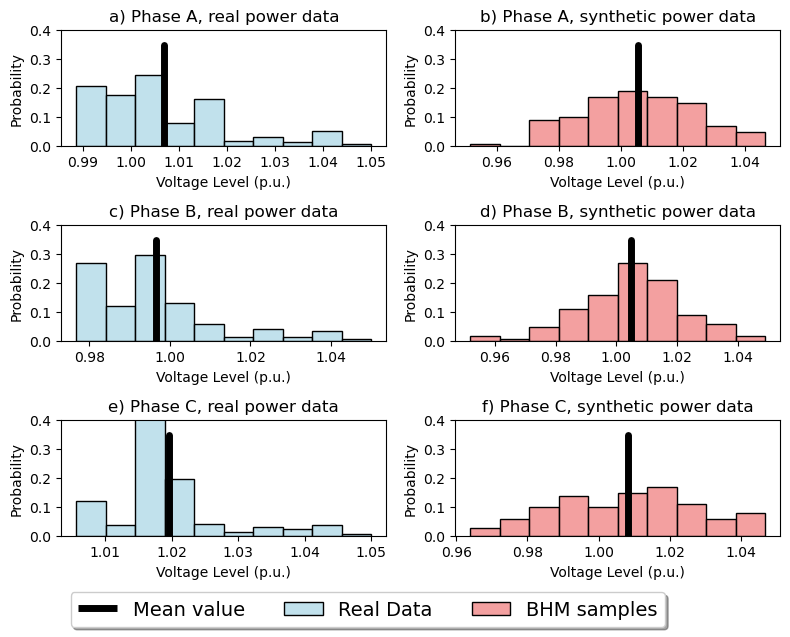

In [30]:
plt.rcParams["figure.figsize"] = (8,6)

fig,axs=plt.subplots(3,2)
#sns.histplot(normalized_power_df,x='p_kw',stat='probability',ax=axs[0])
sns.histplot(net.res_bus_3ph.vm_a_pu,stat='probability',ax=axs[0][0],bins=10,color='lightblue')
axs[0][0].vlines(np.mean(net.res_bus_3ph.vm_a_pu),0,0.35,label='Mean value',colors='black',linewidth=5)
axs[0][0].set_title('a) Phase A, real power data')

sns.histplot(va_list,stat='probability',ax=axs[0][1],bins=10,color='lightcoral',)
axs[0][1].vlines(np.mean(va_list),0,0.35,colors='black',linewidth=5)
axs[0][1].set_title('b) Phase A, synthetic power data')

sns.histplot(net.res_bus_3ph.vm_b_pu,stat='probability',ax=axs[1][0],bins=10,color='lightblue')
axs[1][0].vlines(np.mean(net.res_bus_3ph.vm_b_pu),0,0.35,colors='black',linewidth=5)
axs[1][0].set_title('c) Phase B, real power data')

sns.histplot(vb_list,stat='probability',ax=axs[1][1],bins=10,color='lightcoral')
axs[1][1].vlines(np.mean(vb_list),0,0.35,colors='black',linewidth=5)
axs[1][1].set_title('d) Phase B, synthetic power data')


sns.histplot(net.res_bus_3ph.vm_c_pu,stat='probability',ax=axs[2][0],bins=10,color='lightblue',label='Real Data')
axs[2][0].vlines(np.mean(net.res_bus_3ph.vm_c_pu),0,0.35,colors='black',linewidth=5)
axs[2][0].set_title('e) Phase C, real power data')

sns.histplot(vc_list,stat='probability',ax=axs[2][1],bins=10,color='lightcoral',label='BHM samples')
axs[2][1].vlines(np.mean(vc_list),0,0.35,colors='black',linewidth=5)
axs[2][1].set_title('f) Phase C, synthetic power data')



for ax in axs.flatten():
    ax.set_ylim([0,0.4])
    ax.set_xlabel('Voltage Level (p.u.)')


plt.figlegend( bbox_to_anchor=(0.85, 0.02),
          fancybox=True, shadow=True, ncol=5,fontsize=14)

plt.tight_layout()

